## Graph Neural Networks

### Preface

Unlike other models in the previous chapters, where each is merely a single
specific deep learning architecture, Graph Neural Networks (GNNs) are a whole
bunch of different models that involve graph structures in some way. It is
impossible to thoroughly review them all in a small chapter like this. Instead,
we will focus on a few representative models and leave the rest to the reader.

Here, the model architectures and part of the source code are based on a LAIDD
lecture by Seongok Ryu, Ph.D.* The study materials can be found at the following
locations (mainly in Korean):

- [The LAIDD lecture](https://www.laidd.org/local/ubonline/view.php?id=48)
- [SeongokRyu/LAIDD_GNN](https://github.com/SeongokRyu/LAIDD_GNN) repository for
  the source code used in the lecture

Related GitHub repositories are also available, all provided from the original
lecturer:

- [SeongokRyu/Graph-neural-networks](https://github.com/SeongokRyu/Graph-neural-networks)
- [SeongokRyu/Bayesian-deep-learning](https://github.com/SeongokRyu/Bayesian-deep-learning)
- [AITRICS/mol_reliable_gnn](https://github.com/AITRICS/mol_reliable_gnn)

\* Used with explicit permission.

### GPU selection

Select the GPU id to use.

In [1]:
# Select the right device. Change the number to select a different GPU.
# If you have used slurm to request a GPU, just keep this line as it is.
device_id = 0

In [2]:
import torch
from torch import cuda
from multiprocessing import cpu_count

# Automatic device selection
if cuda.is_available():
    nproc = cpu_count() // cuda.device_count()
    device = torch.device(f"cuda:{device_id}")
else:
    nproc = cpu_count()
    device = torch.device("cpu")

torch.set_num_threads(nproc)
device

device(type='cuda', index=0)

### Hyperparameters

What's the difference? Did you get it?

In [3]:
from dataclasses import dataclass
from typing import Type

from torch import nn, optim


@dataclass
class Params:
    # Training hyperparams
    batch_size: int = 128
    epochs: int = 20

    # Model hyperparams
    model_type: str = "gat"
    num_layers: int = 4
    hidden_dim: int = 64
    num_heads: int = 4  # Only used for GraphTransformer
    dropout: float = 0.2
    bias: bool = True
    Activation: Type[nn.Module] = nn.ReLU
    readout: str = "sum"

    # Optimizer hyperparams
    Optimizer: Type[optim.Optimizer] = optim.Adam
    lr: float = 1e-4

    # Misc
    print_every: int = 4


SEED = 42
params = Params()

### Data preprocessing

Molecules have inherent graph structures, where atoms are nodes and bonds are
edges. SMILES strings or other representations are pretty arbitrary; graphs are
a natural way to represent molecules.

Now we also have to select *features* for nodes (atoms) and edges (bonds). Using
the atom type for nodes and the bond type for edges is natural. Even though the
two features are specific enough to identify a molecule uniquely*, the models
including additional features tend to perform better.

Some available features for nodes are:

- the atom's degree (i.e., the number of bonds between heavy atoms),
- the number of hydrogens it has,
- valency,
- or whether it is a ring or aromatic atom.

For the edges, we can use whether the bond is conjugated or is part of a ring.

We'll use the same dataset (`hERG central`) as the previous chapter; however,
we cannot rely on the SMILES strings as-is this time and must convert them to
molecular graphs. Parsing SMILES strings into molecular structures is not a
trivial task, so let's introduce another external library -
[rdkit](https://github.com/rdkit/rdkit) - to delegate it. Also, to convert the
molecule into graphs, we'll use the [DGL](https://www.dgl.ai/) library.

\* Except stereoisomers.

#### Gathering atom information

Other features have a compact, fixed set of possible classes, but the atomic
number has more than 100 choices if not filtered down, while most are unused.
The first step, thus, will be gathering atomic numbers from the set. The
following code block implements the functionality.

For this time, we need to introduce *multiprocessing*, since parsing a number of
molecules takes significant amount of time.

In [4]:
import functools
from collections import Counter
from collections.abc import Iterable
from typing import List

import numpy as np
from rdkit import Chem
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
from joblib import Parallel, delayed

label_list = retrieve_label_name_list("herg_central")
data = Tox(name='herg_central', label_name=label_list[2])
split = data.get_split()


def get_atomic_nums(smiles: Iterable[str]):
    return Counter(atom.GetAtomicNum()
                   for smi in smiles
                   for atom in Chem.MolFromSmiles(smi).GetAtoms())


# Q) Explain the following line. What's the difference between sequential and
#    parallel processing? Why do we need to chunk the pandas Series object?
mapping = Parallel(n_jobs=nproc)(
    delayed(get_atomic_nums)(smiles)
    for smiles in np.array_split(data.entity1, nproc))
# Q) What will "adding" up all the counter objects produce?
mapping: Counter = functools.reduce(lambda x, y: x + y, mapping)
# Q) Why do we still need to set the starting index to 1? Graphs do not need
#    "padding nodes" generally.
atnum_to_idx = {
    atnum: idx for idx, (atnum, _) in enumerate(mapping.most_common(), 1)}

Found local copy...
Loading...
Done!


#### Creating molecular graphs

Now we can start generating graphs. As stated above, we'll use the DGL library
for this task. Note that for this time, we have multiple features for a single
node, so utilizing a one-hot (actually k-hot, since multiple classes could have
a `1` value) encoding scheme would be easier than creating embedding layers for
each feature and concatenating them.

In [5]:
import dgl
from torch.nn import functional as F

_atom_classes = len(atnum_to_idx) + 1


def get_atom_feature(atom):
    features = [
        F.one_hot(torch.tensor(atnum_to_idx[atom.GetAtomicNum()]),
                  num_classes=_atom_classes),
        # Assume max 5 bonds per each atom
        # Q) Why not 6?
        F.one_hot(torch.tensor(atom.GetDegree()), num_classes=6),
        # Assume max 4 hydrogens per each atom
        F.one_hot(torch.tensor(atom.GetTotalNumHs()), num_classes=5),
        # Assume max valency of 5
        F.one_hot(torch.tensor(atom.GetImplicitValence()), num_classes=6),
        torch.tensor([atom.GetIsAromatic()], dtype=torch.float32)
    ]
    atom_feature = torch.cat(features)
    return atom_feature


_bond_type_to_idx = {
    k: i for i, k in enumerate([
        Chem.BondType.SINGLE,
        Chem.BondType.DOUBLE,
        Chem.BondType.TRIPLE,
        Chem.BondType.AROMATIC,
    ])}


def get_bond_feature(bond):
    bt = bond.GetBondType()
    features = [
        F.one_hot(torch.tensor(_bond_type_to_idx[bt]),
                  num_classes=len(_bond_type_to_idx)),
        torch.tensor(
            [bond.GetIsConjugated(), bond.IsInRing()], dtype=torch.float32),
    ]
    bond_feature = torch.cat(features)
    return bond_feature


def smi_to_graph(smi):
    # Parse SMILES string
    mol = Chem.MolFromSmiles(smi)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    # Build graph
    bond_idxs = torch.tensor(
        [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in bonds])
    # Q) Why do we need the following line?
    bond_idxs = torch.cat([bond_idxs, bond_idxs.flip(1)])
    graph = dgl.graph(tuple(bond_idxs.T), num_nodes=len(atoms))

    # Add node features
    atom_features = torch.stack([get_atom_feature(atom) for atom in atoms])
    graph.ndata["h"] = atom_features

    # Add edge features
    bond_features = torch.stack([get_bond_feature(bond) for bond in bonds])
    bond_features = bond_features.repeat(2, 1)
    graph.edata["e_ij"] = bond_features

    return graph

#### Preparing the dataset

As usual, let's wrap those graphs into a PyTorch dataset.

In [6]:
from pathlib import Path
from typing import Tuple

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


class HergCentralDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        # Again, parallel processing is a good idea.
        # Q) Why couldn't we use the batch_size arg in the previous call to
        #    Parallel?
        self.graphs: List[dgl.DGLHeteroGraph] = Parallel(
            n_jobs=nproc, batch_size=512)(
                delayed(smi_to_graph)(smi) for smi in tqdm(data["Drug"]))
        self.y = torch.tensor(data["Y"].values, dtype=torch.long)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        x = self.graphs[idx]
        y = self.y[idx]
        return x, y

    def save(self, path: str):
        dgl.save_graphs(path, self.graphs, {"y": self.y})

    @classmethod
    def load(cls, path: str):
        graphs, labels = dgl.load_graphs(path)
        self = cls.__new__(cls)
        self.graphs = graphs
        self.y = labels["y"]
        return self

    @staticmethod
    def collate_fn(batch: List[Tuple[dgl.DGLHeteroGraph, torch.Tensor]]):
        x, y = zip(*batch)
        x = dgl.batch(x)
        # Shape: N * (, ) -> (N, )
        y = torch.stack(y)
        return x, y

# Require ~10GB of RAM.
# Q) What should you do if you have less RAM?
try:
    datasets = {k: HergCentralDataset.load(f"resources/{k}.bin")
                for k in split}
except Exception:
    datasets = {k: HergCentralDataset(v) for k, v in split.items()}
    Path("resources").mkdir(exist_ok=True)
    for k, v in datasets.items():
        v.save(f"resources/{k}.bin")

### Graph Neural Networks

#### Graph Convolutional Networks

Graph Convolutional Networks (GCNs) are a family of models that use
"convolutional" layers to process the graph structure. The basic idea is to
convolve the graph structure with a filter, which is a matrix, to obtain a new
graph structure. The filter is applied to each node in the graph, and the
resulting node is a linear combination of the node's neighbors. It is similar
to the convolutional layers in CNNs, but the convolution is applied to graph
structures instead of N-dimensional tensors.

![Graph convolutional layer](../figures/gnn-1.png)

\* Figure by Seongok Ryu, Ph.D.

In [7]:
from torch import nn
from dgl import function as fn


class GraphConv(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 dropout: float = 0.2,
                 bias: bool = True,
                 Activation: Type[nn.Module] = nn.ReLU):
        super().__init__()

        self.linear = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.act = Activation()
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, graph: dgl.DGLHeteroGraph):
        h0 = graph.ndata["h"]

        # What does the following line do?
        graph.update_all(fn.copy_u("h", "m"), fn.sum("m", "u"))
        h = self.linear(graph.ndata["u"])
        h = self.act(h)
        # Q) Why do we add h0?
        h = self.norm(h + h0)
        h = self.dropout(h)

        graph.ndata["h"] = h
        return graph

#### Graph Isomorphism Networks

Graph Isomorphism Networks (GINs) are very similar to the GCNs; the neural
network applied to each node is an MLP, not a linear layer. Theoretically, this
improves the model's ability to learn more complex functions.

We could include not only the node features but also the edge features. Two
following implementations correspond to each case.

In [8]:
class MLP(nn.Sequential):
    def __init__(self, input_dim: int, hidden_dim: int,
                 bias: bool = True,
                 Activation: Type[nn.Module] = nn.ReLU):
        if hidden_dim < input_dim:
            raise ValueError(
                "hidden_dim must be greater than or equal to input_dim.")

        super().__init__(
            nn.Linear(input_dim, hidden_dim, bias=bias),
            Activation(),
            nn.Linear(hidden_dim, input_dim, bias=bias),
        )


class GraphIsomorphism(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 mlp_hidden_dim: int = None,
                 dropout: float = 0.2,
                 bias: bool = True,
                 Activation: Type[nn.Module] = nn.ReLU):
        super().__init__()

        if mlp_hidden_dim is None:
            mlp_hidden_dim = hidden_dim * 4

        self.mlp = MLP(hidden_dim, mlp_hidden_dim,
                       bias=bias, Activation=Activation)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, graph: dgl.DGLHeteroGraph):
        h0 = graph.ndata["h"]

        graph.update_all(fn.copy_u("h", "m"), fn.sum("m", "u"))
        h = self.mlp(graph.ndata["u"])
        h = self.norm(h + h0)
        h = self.dropout(h)

        graph.ndata["h"] = h
        return graph


class GraphIsomorphismEdge(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 mlp_hidden_dim: int = None,
                 dropout: float = 0.2,
                 bias: bool = True,
                 Activation: Type[nn.Module] = nn.ReLU):
        super().__init__()

        if mlp_hidden_dim is None:
            mlp_hidden_dim = hidden_dim * 4

        self.mlp = MLP(hidden_dim, mlp_hidden_dim,
                       bias=bias, Activation=Activation)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, graph: dgl.DGLHeteroGraph):
        h0 = graph.ndata["h"]

        graph.update_all(fn.copy_u("h", "m_n"), fn.sum("m_n", "u_n"))
        graph.update_all(fn.copy_e("e_ij", "m_e"), fn.sum("m_e", "u_e"))
        u = graph.ndata["u_n"] + graph.ndata["u_e"]

        h = self.mlp(u)
        h = self.norm(h + h0)
        h = self.dropout(h)

        graph.ndata["h"] = h
        return graph

#### Graph Transformers

Graph Transformers, or Graph Attention Networks are also similar to the GCNs;
they take account of the node's neighbors, but instead of a linear combination,
they use an attention mechanism to compute the node's representation.

Multiple architectures fall under this category, yet we'll implement (a slightly
modified version of) the one introduced in the paper "Masked Label Prediction:
Unified Message Passing Model for Semi-Supervised Classification"
(*arXiv*:2009.03509). It is called a `TransformerConv` network in the
[pytorch-geometric library](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.TransformerConv).

We selected this model because it uses a more cost-efficient attention mechanism
than the original Graph Attention Network (GAT) model introduced in the paper
"Graph Attention Networks" (*arXiv*:1710.10903).

![Graph attention network](../figures/gnn-2.png)

\* Figure by Seongok Ryu, Ph.D. Represents GAT.

In [9]:
import math

from dgl.nn import functional as GF


class GraphMultiheadAttention(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 num_heads: int = 4,
                 bias: bool = True,
                 Activation: Type[nn.Module] = nn.ReLU):
        super().__init__()
        if hidden_dim % num_heads:
            raise ValueError("hidden dimension must be divisible by num_heads")

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.splitted_dim = hidden_dim // num_heads
        self._inv_sqrt_dim = 1 / math.sqrt(self.splitted_dim)

        def linear():
            return nn.Linear(hidden_dim, hidden_dim, bias=bias)

        self.e = linear()
        self.n_q = linear()
        self.n_k = linear()
        self.n_v = linear()
        self.n_h0 = linear()

    def forward(self, graph: dgl.DGLHeteroGraph):
        h0 = graph.ndata["h"]
        e0 = graph.edata["e_ij"]

        # Notations taken from pytorch_geometric (https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.TransformerConv)
        # q = W_3 x_i
        graph.ndata["q"] = self.n_q(h0).view(
            -1, self.num_heads, self.splitted_dim)
        # k = W_4 x_j
        graph.ndata["k"] = self.n_k(h0).view(
            -1, self.num_heads, self.splitted_dim)
        # v = W_2 x_j
        graph.ndata["v"] = self.n_v(h0).view(
            -1, self.num_heads, self.splitted_dim)
        # x_ij = W_6 e_ij
        graph.edata["x_ij"] = self.e(e0).view(
            -1, self.num_heads, self.splitted_dim)

        # k = k + x_ij
        graph.apply_edges(fn.u_add_e("k", "x_ij", "k"))
        # a = q^T @ m
        graph.apply_edges(fn.v_dot_e("q", "k", "a"))
        # a = softmax(a / sqrt(d_k))
        graph.edata["a"] = GF.edge_softmax(
            graph, graph.edata["a"] * self._inv_sqrt_dim)

        # v = v + x_ij
        graph.apply_edges(fn.u_add_e("v", "x_ij", "v"))
        # m = a * v
        graph.edata["m"] = graph.edata["a"] * graph.edata["v"]
        # h = sum(m)
        graph.update_all(fn.copy_e("m", "m"), fn.sum("m", "h"))

        # h = W_1 x_i + h
        h = graph.ndata["h"].view(-1, self.hidden_dim)
        h = self.n_h0(h0) + h

        graph.ndata["h"] = h
        return graph


class GraphTransformer(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 mlp_hidden_dim: int = None,
                 num_heads: int = 4,
                 bias: bool = True,
                 Activation: Type[nn.Module] = nn.ReLU,
                 dropout: float = 0.2):
        super().__init__()

        if mlp_hidden_dim is None:
            mlp_hidden_dim = hidden_dim * 4

        self.attention = GraphMultiheadAttention(
            hidden_dim, num_heads, bias=bias, Activation=Activation)
        self.a_dropout = nn.Dropout(dropout)
        self.a_norm = nn.LayerNorm(hidden_dim)

        self.mlp = MLP(
            hidden_dim, mlp_hidden_dim, bias=bias, Activation=Activation)
        self.l_dropout = nn.Dropout(dropout)
        self.l_norm = nn.LayerNorm(hidden_dim)

    def forward(self, graph: dgl.DGLHeteroGraph):
        graph = self.attention(graph)

        h0 = graph.ndata["h"]
        h1 = self.a_dropout(h0)
        h1 = self.a_norm(h1)

        h2 = self.l_dropout(self.mlp(h1))
        h = self.l_norm(h1 + h2)

        graph.ndata["h"] = h
        return graph

#### Main model

Now we can implement the main model. Note that we also need some embedding
layers for mapping the input features into a (latent) vector space.

In [10]:
from functools import partial

_dummy = Chem.MolFromSmiles("CC")
atom_feature_dim = get_atom_feature(_dummy.GetAtomWithIdx(0)).shape[0]
bond_feature_dim = get_bond_feature(_dummy.GetBondWithIdx(0)).shape[0]


class GNNClassifier(nn.Module):
    def __init__(self, params: Params):
        super().__init__()

        self.params = params
        self.embedding_node = nn.Linear(
            atom_feature_dim, params.hidden_dim, bias=False)
        self.embedding_edge = nn.Linear(
            bond_feature_dim, params.hidden_dim, bias=False)

        # What is the following code doing?
        if params.model_type == "gcn":
            Gnn = GraphConv
        elif params.model_type == "gin":
            Gnn = GraphIsomorphism
        elif params.model_type == "gin_e":
            Gnn = GraphIsomorphismEdge
        elif params.model_type == "gat":
            Gnn = partial(GraphTransformer, num_heads=params.num_heads)
        else:
            raise ValueError("Unknown model type")

        # Why do we need to use partial instead of calling Gnn directly?
        gnn_factory = partial(Gnn, params.hidden_dim,
                              dropout=params.dropout, bias=params.bias,
                              Activation=params.Activation)
        self.gnn = nn.Sequential(
            *(gnn_factory() for _ in range(params.num_layers)))

        self.projection = nn.Linear(params.hidden_dim, 2, bias=False)

    def forward(self, graph: dgl.DGLHeteroGraph):
        h = self.embedding_node(graph.ndata["h"].float())
        e_ij = self.embedding_edge(graph.edata["e_ij"].float())
        graph.ndata["h"] = h
        graph.edata["e_ij"] = e_ij

        graph = self.gnn(graph)
        h = dgl.readout_nodes(graph, "h", op=self.params.readout)

        out = self.projection(h)
        return out

### Training and validation code

They are all directly imported from the previous chapter.

In [11]:
import random

import numpy as np
from sklearn import metrics
from tqdm import tqdm, trange


class Callbacks:
    def __init__(self, model: nn.Module):
        self.model = model

    def on_epoch_begin(self):
        pass

    def on_batch_begin(self):
        pass

    def on_batch_end(self, loss: torch.Tensor):
        pass


class TrainingCallback(Callbacks):
    def __init__(self, model: nn.Module, optim: torch.optim.Optimizer):
        super().__init__(model)
        self.optim = optim

    def on_epoch_begin(self):
        self.model.train()

    def on_batch_begin(self):
        self.optim.zero_grad()

    def on_batch_end(self, loss: torch.Tensor):
        loss.backward()
        self.optim.step()


class ValidationCallback(Callbacks):
    def on_epoch_begin(self):
        self.model.eval()


def run(model: nn.Module, criterion: nn.Module,
        loader: DataLoader, callbacks: Callbacks):
    callbacks.on_epoch_begin()

    epoch_loss = []
    epoch_true = []
    epoch_pred = []

    for g, y in loader:
        callbacks.on_batch_begin()

        g = g.to(device)
        y = y.to(device)

        y_hat = model(g)
        loss = criterion(y_hat, y)

        callbacks.on_batch_end(loss)
        epoch_loss.append(loss.item())

        epoch_true.append(y.cpu().numpy())
        epoch_pred.append(y_hat.argmax(dim=1).cpu().numpy())

    epoch_true = np.concatenate(epoch_true)
    epoch_pred = np.concatenate(epoch_pred)

    epoch_accu = metrics.accuracy_score(epoch_true, epoch_pred)
    epoch_f1 = metrics.f1_score(epoch_true, epoch_pred)

    return np.mean(epoch_loss), epoch_accu, epoch_f1


def train(model: nn.Module, criterion: nn.Module,
          loader: DataLoader, optimizer: optim.Optimizer):
    callbacks = TrainingCallback(model, optimizer)
    return run(model, criterion, loader, callbacks)


@torch.no_grad()
def validate(model: nn.Module, criterion: nn.Module, loader: DataLoader):
    callbacks = ValidationCallback(model)
    return run(model, criterion, loader, callbacks)


def train_gnn(model: GNNClassifier, criterion: nn.Module,
              train_loader, valid_loader):
    optimizer = params.Optimizer(model.parameters(), lr=params.lr)
    stats = []

    for epoch in trange(1, params.epochs + 1):
        train_loss, train_acc, train_f1 = train(
            model, criterion, train_loader, optimizer)
        valid_loss, valid_acc, valid_f1 = validate(
            model, criterion, valid_loader)

        if not epoch % params.print_every or epoch in (1, params.epochs):
            tqdm.write(
                f"{train_loss = :.4f}, {train_acc = :.2%}, {train_f1 = :.4f}, "
                f"{valid_loss = :.4f}, {valid_acc = :.2%}, {valid_f1 = :.4f}")

        stats.append((epoch, train_loss, train_acc, train_f1,
                      valid_loss, valid_acc, valid_f1))

    stats = pd.DataFrame.from_records(stats, columns=[
        "epoch", "train_loss", "train_accu", "train_f1",
        "valid_loss", "valid_accu", "valid_f1"])
    return stats


In [12]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")


def seed_everything(seed=SEED):
    """Seed all the random number generators for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def to_dataloader(dataset, batch_size: int, shuffle: bool = False):
    return DataLoader(dataset, batch_size, shuffle=shuffle,
                      collate_fn=dataset.collate_fn,
                      generator=torch.Generator().manual_seed(SEED))


def get_dataloaders():
    return (to_dataloader(v, params.batch_size, k == "train")
            for k, v in datasets.items())


def print_model_summary(model: nn.Module):
    param_cnt = sum(param.numel()
                    for param in model.parameters() if param.requires_grad)

    print(model)
    print(f"Model has {param_cnt:,} trainable parameters")


def plot_stats(stats: pd.DataFrame):
    stats_long = stats.melt(
        id_vars="epoch", var_name="type", value_name="stat")
    stats_long["run"] = [tp.split("_")[0] for tp in stats_long["type"]]
    stats_long["type"] = [tp.split("_")[1] for tp in stats_long["type"]]

    epochs = params.epochs
    fg = sns.relplot(x="epoch", y="stat", data=stats_long,
                     hue="run", col="type", marker="o", kind="line",
                     col_order=["loss", "accu", "f1"],
                     facet_kws={"sharey": False, "xlim": (1, epochs + 1)})
    for ax in fg.axes[0, 1:]:
        ax.set_ylim(0, 1)

    xticks = list(range(1, epochs + 1, params.print_every))
    if epochs != xticks[-1]:
        xticks.append(epochs)
    fg.set(xticks=xticks)
    plt.show()


@torch.no_grad()
def draw_confusion_matrix(model: nn.Module, valid_loader: DataLoader):
    model.eval()

    y_true = []
    y_pred = []
    for X, y in valid_loader:
        y_true.append(y.numpy())

        y_hat = model(X.to(device))
        y_pred.append(y_hat.argmax(dim=1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    print(y_true.mean(), y_pred.mean())


### Model training and hyperparameter optimization

In [13]:
def main(criterion, train_loader, valid_loader):
    seed_everything()

    model = GNNClassifier(params).to(device)
    # Visualize the model
    print_model_summary(model)

    stats = train_gnn(model, criterion, train_loader, valid_loader)
    plot_stats(stats)

    return model


train_set = datasets["train"]

total = len(train_set)
pos_freq = train_set.y.sum().item() / total
w = torch.tensor([pos_freq, 1 - pos_freq])
w *= len(w)

criterion = nn.CrossEntropyLoss(weight=w).to(device)

Now, the final step. Do your experiments and find the best model!

GNNClassifier(
  (embedding_node): Linear(in_features=45, out_features=64, bias=False)
  (embedding_edge): Linear(in_features=6, out_features=64, bias=False)
  (gnn): Sequential(
    (0): GraphTransformer(
      (attention): GraphMultiheadAttention(
        (e): Linear(in_features=64, out_features=64, bias=True)
        (n_q): Linear(in_features=64, out_features=64, bias=True)
        (n_k): Linear(in_features=64, out_features=64, bias=True)
        (n_v): Linear(in_features=64, out_features=64, bias=True)
        (n_h0): Linear(in_features=64, out_features=64, bias=True)
      )
      (a_dropout): Dropout(p=0.2, inplace=False)
      (a_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=64, bias=True)
      )
      (l_dropout): Dropout(p=0.2, inplace=False)
      (l_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
 

  5%|▌         | 1/20 [01:25<26:58, 85.19s/it]

train_loss = 0.8215, train_acc = 59.15%, train_f1 = 0.1174, valid_loss = 0.6131, valid_acc = 70.20%, valid_f1 = 0.1564


 20%|██        | 4/20 [05:12<20:33, 77.10s/it]

train_loss = 0.5953, train_acc = 70.73%, train_f1 = 0.1746, valid_loss = 0.5807, valid_acc = 81.46%, valid_f1 = 0.2212


 40%|████      | 8/20 [10:14<15:09, 75.81s/it]

train_loss = 0.5643, train_acc = 73.80%, train_f1 = 0.1957, valid_loss = 0.6053, valid_acc = 58.71%, valid_f1 = 0.1502


 60%|██████    | 12/20 [15:18<10:06, 75.80s/it]

train_loss = 0.5499, train_acc = 74.88%, train_f1 = 0.2054, valid_loss = 0.5448, valid_acc = 73.72%, valid_f1 = 0.2006


 80%|████████  | 16/20 [20:21<05:03, 75.84s/it]

train_loss = 0.5410, train_acc = 75.41%, train_f1 = 0.2111, valid_loss = 0.5359, valid_acc = 73.09%, valid_f1 = 0.2009


100%|██████████| 20/20 [25:25<00:00, 76.29s/it]


train_loss = 0.5295, train_acc = 76.07%, train_f1 = 0.2183, valid_loss = 0.5282, valid_acc = 75.05%, valid_f1 = 0.2099


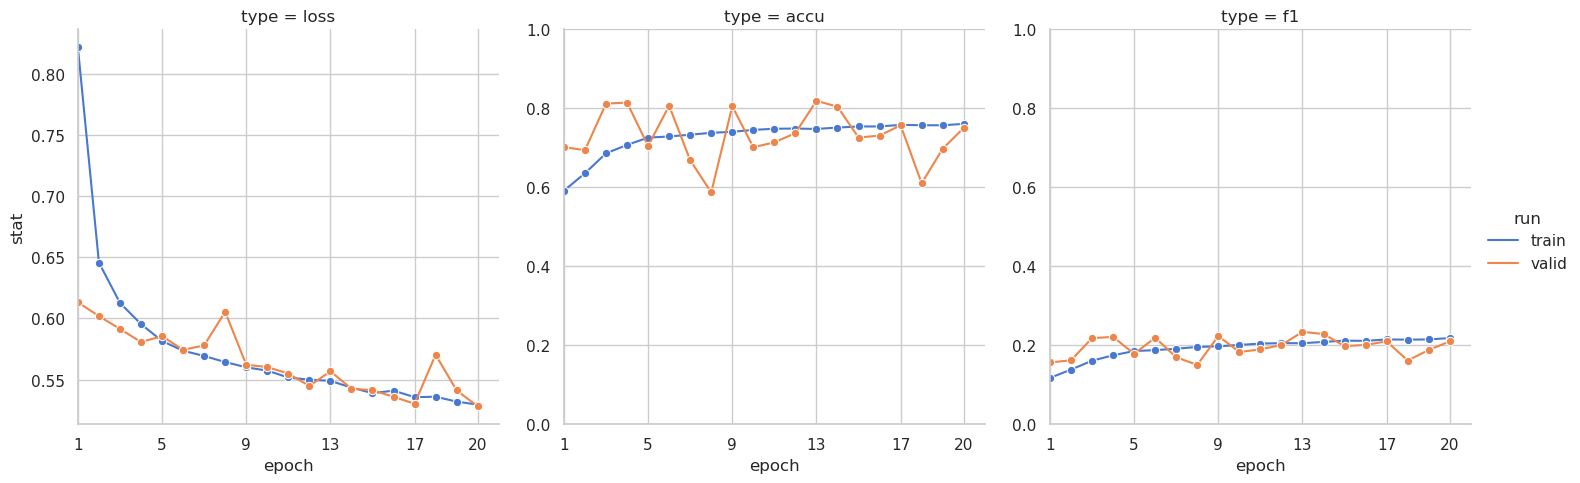

0.04324024894913487 0.272573234709505


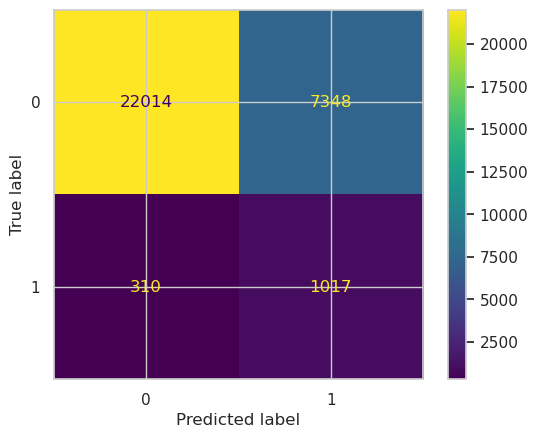

In [14]:
train_loader, valid_loader, test_loader = get_dataloaders()
model = main(criterion, train_loader, valid_loader)
draw_confusion_matrix(model, valid_loader)

### Model evaluation

Once satisfied with the model, you can evaluate the final model on the test set.
This is your *score* on this problem. Never be tempted to evaluate the model on
the test set beforehand: it's cheating.

In [15]:
validate(model, criterion, test_loader)

(0.525352418422699, 0.7483015363560827, 0.21110146555686052)